# Discrete Distributions in Time

## Introduction

### Question: Can we find temporal anomalies in PDFs?

1. Quantize streamflow signal.
2. Make bins "selectable".
3. highlight bin data in time series.
4. Do a test of temporal distribution of bin values.

i.e. in the image below, does the "mode" around 1.5 $m^3/s$ occur in one season or does it appear across many seasons?

Are there temporal clusters that have a periodicity, or is it a once in 36 year anomaly?

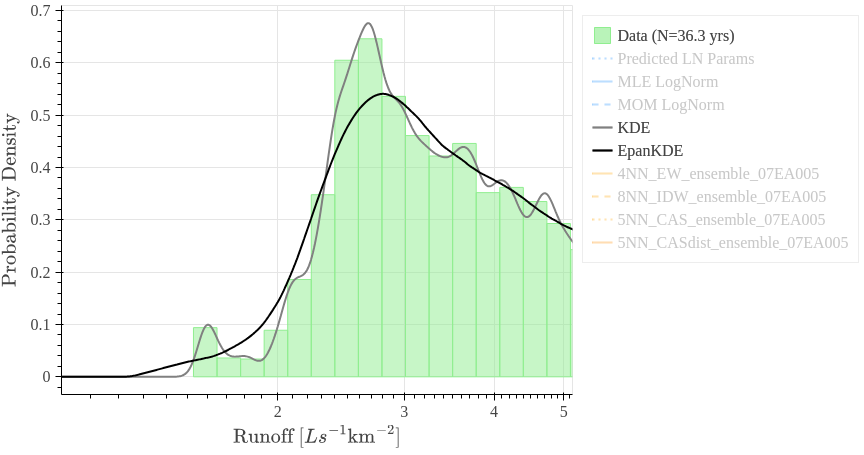


## Data Import and Model Setup

In [1]:
import os
import pandas as pd
import numpy as np
from time import time

import geopandas as gpd
from shapely.geometry import Point
import xyzservices.providers as xyz

from bokeh.plotting import figure, show
from bokeh.layouts import gridplot, row, column
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.models import ColumnDataSource, LinearAxis, Range1d
from bokeh.io import output_notebook
from bokeh.palettes import Sunset10, Vibrant7, Category20, Bokeh6, Bokeh7, Bokeh8, Greys256

import xgboost as xgb
xgb.config_context(verbosity=2)

from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    roc_auc_score,
    roc_curve, auc,
    accuracy_score,
    confusion_matrix,
)

from scipy.stats import linregress
from scipy.stats import lognorm, norm
from scipy.special import kl_div


import jax
import jax.numpy as jnp
from jax.scipy.stats import gaussian_kde as jkde
from jax import config as jax_config
jax_config.update("jax_enable_x64", False)

from jax import jit
from jax import vmap

from KDEpy import FFTKDE

import data_processing_functions as dpf

import multiprocessing as mp
from functools import partial

# from sklearn.model_selection import StratifiedKFold
output_notebook()

Loading BokehJS ...

In [2]:
BASE_DIR = os.getcwd()
tiles = xyz['USGS']['USTopo']


In [3]:
# load the catchment characteristics
fname = 'BCUB_watershed_attributes_updated.csv'
attr_df = pd.read_csv(os.path.join('data', fname))
attr_df['log_drainage_area_km2'] = np.log(attr_df['drainage_area_km2'])
attr_df.columns = [c.lower() for c in attr_df.columns]
attr_df['tmean'] = (attr_df['tmin'] + attr_df['tmax']) / 2.0
station_ids = attr_df['official_id'].values
print(f'There are {len(station_ids)} monitored basins in the attribute set.')

There are 1325 monitored basins in the attribute set.


In [4]:
centroids = attr_df.apply(lambda row: Point(row['centroid_lon_deg_e'], row['centroid_lat_deg_n']), axis=1)
attr_gdf = gpd.GeoDataFrame(attr_df, geometry=centroids, crs='EPSG:4326')
attr_gdf.drop('unnamed: 0', inplace=True, axis=1)
attr_gdf.reset_index(inplace=True)
# convert to BC Albers for computing distances
attr_gdf = attr_gdf.to_crs(3005)

In [7]:
from bokeh.models import Div
from bokeh.layouts import layout

def create_plot(log_data):

    fig = figure(width=900, height=450, x_axis_type='log')
    hist, log_edges = np.histogram(log_data, bins=2**6, density=True)
    edges = np.exp(log_edges)

    # convert density to mass
    cdf = np.cumsum(hist)
    cdf /= cdf[-1]
    pmf = np.diff(cdf, prepend=cdf[0])
    pmf /= pmf.sum()
    yrs = len(log_data) / 365
    fig.quad(bottom=0, left=edges[:-1], right=edges[1:], top=hist, color='lightgreen', fill_alpha=0.5, legend_label=f'Data (N={yrs:.1f} yrs)')
    show(fig)

In [13]:
def quantize_signal(target_stn, da, n_bins=2*6):
    print(f'Processing {target_stn}')
    # import streamflow data
    stn_df = dpf.get_timeseries_data(stn)
    stn_df[f'{target_stn}_uar'] = 1000 * stn_df[target_stn] / da
    data = stn_df[f'{target_stn}_uar'].dropna().values
    log_data = np.log(data)

    epsilon = 1e-6 
    minx, maxx = np.min(data) - epsilon, np.max(data) + epsilon
    le, re = -1, 1
    log_grid = np.linspace(np.log(minx) + le, np.log(maxx) + re, n_bins)
    lin_grid = np.exp(log_grid)
    create_plot(log_data)
    

In [14]:
to_check = ['05AD003','05AD031', '05AB022', '05AB030', '05AD031', '12091050']

for i, row in attr_gdf.iterrows():
    stn = row['official_id']
    da = row['drainage_area_km2']
    quantize_signal(stn, da)
    print(asdf)

    

Processing 05010500


NameError: name 'asdf' is not defined

## Assign cluster numbers to stratify k-fold validation clusters

In [ ]:
# load the cluster information from the Methods section 
# where we partitioned the graph to evaluate the distribution
# of the target variable across folds
# n_clusters = 15
# for spatial clustering
# cluster_fname = f'stn_attributes_with_assigned_cluster_{n_clusters}.geojson'
# for distributed classification (alternating labels spatially)
n_classes = 5
cluster_fname = f'stn_attributes_with_{n_classes}_spatial_partitions.geojson'
cluster_ids = gpd.read_file(os.path.join('data', cluster_fname))
cluster_ids.head()

In [ ]:
# attr_df['cluster_id'] = attr_df['official_id'].apply(lambda x: cluster_ids.loc[cluster_ids['official_id'] == x, 'cluster'].values[0])
attr_df['cluster_id'] = attr_df['official_id'].apply(lambda x: cluster_ids.loc[cluster_ids['official_id'] == x, f'{n_classes}_spatial'].values[0])
# check the number of station per fold
f_unique, f_counts = np.unique(attr_df['cluster_id'], return_counts=True)

### Pre-load the results to avoid repeat loads in the model training iterations

In [ ]:
target_label = 'DKL_akde_LN_est'
print(dkl_df[target_label].min(), dkl_df[target_label].max())

In [ ]:
order_dict = {}
percentiles = np.linspace(0, 100, 1000)
distribution_plots = []

dfig = figure(title=f"", width=500, height=400, x_axis_type='log')#,
             # x_axis_type='log')
n = 0
# compute empirical cdf of "Actual" Target
# values = partial_counts[c].copy().dropna()
con_vals = dkl_df[target_label].copy().dropna()

# print(f'{b}bits, 10^{prior} prior min dkl: {minv:.1e}, max dkl: {maxv:.1F}')
con_sample_vals = np.percentile(con_vals, percentiles)

# Calculate the CDF values
con_cdf_values = np.arange(1, len(con_sample_vals) + 1) / len(con_sample_vals)
dfig.line(con_sample_vals, con_cdf_values, color=Category20[17][n], 
          line_width=2.5, legend_label=f'Concurrent')

dfig.legend.location ='bottom_right'
dfig.xaxis.axis_label = r'$$D_{\text{KL}} [\text{bits}/\text{sample}]$$'
dfig.yaxis.axis_label = r'$$\text{Pr}(x \leq X)$$'
dfig.legend.ncols = 1
dfig.legend.click_policy = 'hide'
dfig = dpf.format_fig_fonts(dfig, font_size=15)

In [ ]:
show(dfig)

### Check CDFs based on support coverage flags

Find the following:

1. Separate the dataset into two groups base on the `underspecified_model_flag` which represents models where the support of $Q$ does not cover the support of $P$.

In [ ]:
dkl_df.columns
dkl_df.head()

In [ ]:
# check for duplicate index entries
dkl_df.index = dkl_df['proxy'] + '_' + dkl_df['target']
print(len(dkl_df))
dkl_df = dkl_df[~dkl_df.index.duplicated(keep='first')]
print(len(dkl_df))

In [ ]:
cls = ['concurrent', 'nonconcurrent']
p = figure(width=500, height=400, x_axis_type='log')

sc_df = dkl_df[dkl_df['incomplete_target_support_coverage'] == False].copy()
ncsc_df = dkl_df[dkl_df['incomplete_target_support_coverage'] == True].copy()

covered = sc_df[label].dropna()
non_covered = ncsc_df[label].dropna()
pct_concurrent_covered = len(covered) / len(dkl_df)
print(f'N={len(covered)} (complete), N={len(non_covered)} (incomplete) coverage ({100*pct_concurrent_covered:.0f}%)')
covered_pvals = np.percentile(covered, percentiles)
noncovered_pvals = np.percentile(non_covered, percentiles)
p50_covered = np.percentile(covered, 50)
p50_nc = np.percentile(non_covered, 50)
p.line(covered_pvals, percentiles, line_width=2, line_dash='solid', 
       color='green', legend_label=f'Complete SC (Median={p50_covered:.2f})')
p.line(noncovered_pvals, percentiles, line_width=2, line_dash='dashed', 
       color='dodgerblue', legend_label=f'Incomplete SC (Median={p50_nc:.2f})')
p.legend.location='top_left'
p.legend.background_fill_alpha = 0.6
p.xaxis.axis_label = r'$$D_{\text{KL}} [\text{bits}/\text{sample}]$$'
p.yaxis.axis_label = r'$$Pr(x \leq X)$$'
p.legend.click_policy='hide'
p = dpf.format_fig_fonts(p, font_size=14)

In [ ]:
show(p)

### Load pairwise attribute comparisons

Load a few rows from one of the pairwise data files.  These contain attributes about divergence measures that are computed on concurrent and non-concurrent time series at two monitored locations.

### Define attribute groupings

In [ ]:
terrain = ['drainage_area_km2', 'elevation_m', 'slope_deg', 'aspect_deg'] #'gravelius', 'perimeter',
land_cover = [
    'land_use_forest_frac_2010', 'land_use_grass_frac_2010', 'land_use_wetland_frac_2010', 'land_use_water_frac_2010', 
    'land_use_urban_frac_2010', 'land_use_shrubs_frac_2010', 'land_use_crops_frac_2010', 'land_use_snow_ice_frac_2010']
soil = ['logk_ice_x100', 'porosity_x100']
climate = ['prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp', 'high_prcp_freq', 'high_prcp_duration', 'low_prcp_freq', 'low_prcp_duration']
all_attributes = terrain + land_cover + soil + climate
len(all_attributes)

In [ ]:
# create the fold dictionary to initialize the train/test split for each fold
def create_fold_dict(df):
    cluster_ids = sorted(list(set(attr_df['cluster_id'].values)))
    print(f'The fold ids are: {cluster_ids}')
    fold_dict = {}
    for c in cluster_ids:
        cluster_stns = attr_df.loc[attr_df['cluster_id'] == c, 'official_id'].values
        # in-group edges
        sample_AND = df[(df['proxy'].isin(cluster_stns)) & (df['target'].isin(cluster_stns))].copy()
        # out-of-group edges
        sample_NOR = df[(~df['proxy'].isin(cluster_stns)) & (~df['target'].isin(cluster_stns))].copy()
        # assert that these are mutually exclusive groups
        and_official_ids = set(sample_AND['proxy'].values + sample_AND['target'].values)
        nor_official_ids = set(sample_NOR['proxy'].values + sample_NOR['target'].values)
        assert len(list(set(np.intersect1d(and_official_ids, nor_official_ids)))) == 0, 'stations in list are not unique'
        fold_dict[c] = {
            'test': sample_AND.index.values,
            'train': sample_NOR.index.values,
        }
    return fold_dict        

In [ ]:
def format_features(input_attributes):
    features = []
    for a in input_attributes:
        features.append(f"proxy_{a}".lower())
        features.append(f"target_{a}".lower())
    return features

def add_attributes(attr_df, df, attribute_cols):
    """
    Adds attributes from the df_attributes to the df_relations based on the 'proxy' and 'target' columns
    using map for efficient lookups.

    Parameters:
    df_attributes (pd.DataFrame): DataFrame with 'id' and attribute columns.
    df_relations (pd.DataFrame): DataFrame with 'proxy' and 'target' columns.
    attribute_cols (list of str): List of attribute columns to add to df_relations.

    Returns:
    pd.DataFrame: Updated df_relations with added attribute columns.
    """
    # Create dictionaries for each attribute for quick lookup
    attr_dicts = {col: attr_df.set_index('official_id')[col].to_dict() for col in attribute_cols}

    # Add target attributes
    for col in attribute_cols:
        df[f'target_{col}'] = df['target'].map(attr_dicts[col])

    # Add proxy attributes
    for col in attribute_cols:
        df[f'proxy_{col}'] = df['proxy'].map(attr_dicts[col])

    for col in attribute_cols:
        df[f'{col}_diff'] = df[f'target_{col}'] - df[f'proxy_{col}'] 

    return df

### Regression Problem

The same problem setup applies for the regression prediction problem which is to optimize the discriminant function and the input signal quantization simultaneously to minimize the error in predicting the KL divergence from catchment attributes.  

Instead of predicting a scalar measure which is a feature of a single location, the key difference in this step is the target variable describes a measure of the difference in runoff between **pairs of locations**.  This approach asks whether the **Kullback-Leibler Divergence** (KLD) of the distribution of unit area runoff between two locations can be predicted from the attributes of both catchments (and their differences) using the gradient boosted decision tree method, which is also capable of predicting continuous variables, in this case $D_{KL}$.

### Set trial parameters

In [ ]:
# define the amount of data to set aside for final testing
# n_cv_folds = 5
n_boost_rounds = 1000
random_seed = 42
loss_function = 'reg:absoluteerror'  # L1 objective function for regression

#define if testing concurrent or nonconcurrent data

# partial counts refer to the test where observations were assigned
# a uniform distribution to approximate error and allow fractional 
# observations in state space

# cross validation parameters
optimize_cv_folds = False
cv_fold_seed = 83561
n_cv_fold_optimization_trials = 15
# limit the maximum distance to make the network 
# graph of station pairs more separable
max_centroid_distance = 1000

attribute_set_names = ['proximity', '+climate', '+terrain', '+land_cover', '+soil']
attribute_group_sets = [['centroid_distance'], climate, terrain, land_cover, soil]

In [ ]:
results_folder = os.path.join(BASE_DIR, 'data', 'prediction_results', 'predicted_LN_kld_prediction_results')
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

### Train-Test Split

The input dataset is pairwise comparisons of just over 1300 (streamflow) monitored catchments, their attributes, and the attribute differences.  After filtering for data concurrency (minimum 1 year, < 5 days missing per month) and maximum distance between basin centroids (500 km) we are left with roughly 225K pairs.  The pairwise setup means that station data appears in more than one row.  As a result, the attributes of stations can end up in both training and test sets if we simply split by randomly assigning rows to training or test sets.   We can't simply cut edges until the graph is separated because it is a [generalization of the "keeping a subset of vertices" problem in graph theory which is NP-hard](https://en.wikipedia.org/wiki/Independent_set_(graph_theory)).

To address this issue we split the dataset spatially to create partitioned datasets for each fold and draw samples from within the "cluster" while filtering all edges between the fold and the rest of the set.  The end goal is to generate training folds where the official_id does not appear in both training and test set, in either proxy or target column.  One problem remains, and that is to generate training and test sets with some assurance that the target variable distributions match to some degree, but this is less critical than ensuring there is no data leakage between training and test data.  

Next we create training/test splits and visualize how the target variable distributions compare.


In [ ]:
def compute_empirical_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

In [ ]:
def load_result_by_prior(prior, binary=False):
    rf = os.path.join('data', 'kde_kld_prediction_results')
    fname = f'kde_dkl_{concurrent}_results.npy'
    fpath = os.path.join(rf, fname)
    return np.load(fpath, allow_pickle=True).item()

In [ ]:
def train_xgb_model(
    input_data, fold_no, cv_data, attributes, target, params, num_boost_rounds, loss
):    
    test_idxs = cv_data['test']
    train_idxs = cv_data['train']   

    test_data = input_data.iloc[test_idxs, :].copy()
    train_data = input_data.iloc[train_idxs, :].copy()

    X_train = train_data[attributes].values
    Y_train = train_data[target].values
    # Y_train = np.log10(train_data[target].values)
    X_test = test_data[attributes].values
    Y_test = test_data[target].values
    # Y_test = np.log10(test_data[target].values)

    # model = xgb.XGBRegressor(**params)

    dtrain = xgb.DMatrix(X_train, label=Y_train)
    dtest = xgb.DMatrix(X_test, label=Y_test)

    eval_list = [(dtrain, "train"), (dtest, "eval")]
    evals_result = {}
    bst = xgb.train(
        params,
        dtrain,
        num_boost_rounds,
        evals=eval_list,
        evals_result=evals_result,
        verbose_eval=0,
    )
    eval_keys = list(evals_result['train'].keys())
    if len(eval_keys) > 1:
        print(f' setting eval key to {eval_keys[0]} from {eval_keys}')

    eval_key = eval_keys[0]
    # Convert the lists to NumPy arrays with dtype=object
    train_perf = np.array(evals_result['train'][eval_key], dtype=object)
    test_perf = np.array(evals_result['eval'][eval_key], dtype=object)
    fold_progress = pd.DataFrame({
        'train': evals_result['train'][eval_key],
        'test': evals_result['eval'][eval_key],
        'fold': [fold_no]*len(evals_result['train'][eval_key]),
    })
    predicted = bst.predict(dtest)

    return train_perf, test_perf, fold_progress, predicted, Y_test

In [ ]:
def run_xgb_trials_custom_CV(
    set_name,
    attributes,
    target,
    input_data,
    fold_dict, 
    n_optimization_rounds,
    num_boost_rounds,
    results_folder,
    loss='reg:squarederror',
    random_seed=42
):
    """
    Custom CV refers to cross validation.  Custom cross validation means the 
    held-out set must be determined in a more robust way to avoid "data leakage".
    That is, the pairs making up the training, validation, and test sets must 
    be made up of pairings from unique sets of stations.
    """
    # select random hyperparameters for n_optimization_rounds
    sample_choices = np.arange(0.5, 0.9, 0.02)  # subsample and colsample percentages
    lr_choices = np.arange(0.001, 0.1, 0.0005)  # learning rates
    learning_rates = np.random.choice(lr_choices, n_optimization_rounds)
    subsamples = np.random.choice(sample_choices, n_optimization_rounds)
    colsamples = np.random.choice(sample_choices, n_optimization_rounds)
    num_boost_rounds = num_boost_rounds
    eval_key = loss.split(':')[1]

    all_results = []
    best_result = (None, np.inf, None)
    best_params = None
    best_mean_test_perf = np.inf
    best_convergence_df = pd.DataFrame()
    best_trial_test_predictions = None
    output_target_cdfs = None
    for trial in range(n_optimization_rounds):
        lr, ss, cs = learning_rates[trial], subsamples[trial], colsamples[trial]
        params = {
            "objective": loss,
            "eta": lr,
            # "max_depth": 6,  # use default max_depth
            # "min_child_weight": 1, # use colsample and subsample instead of min_child_weight
            "subsample": ss,
            "colsample_bytree": cs,
            "seed": random_seed,
            "device": "cuda",  # note, change this to 'cpu' if your system doesn't have a CUDA GPU
            "sampling_method": "gradient_based",
            "tree_method": "hist",
        }

        results_fname = (
            f"{set_name}_{lr:.3f}_lr_{ss:.3f}_sub_{cs:.3f}_col.csv"
        )
        results_fpath = os.path.join(results_folder, results_fname)

        # k-fold cross validation
        fold_scores = []
        n_samples = len(input_data)
        fold_no = 0
        best_train_fold_perf, best_test_fold_perf, best_test_rounds = [], [], []
        all_fold_results = []
        fold_scores, fold_arrays = [], []
        target_cdfs = []
        for fold_no, cv_data in fold_dict.items():
            train_perf, test_perf, fold_progress, predicted, Y_test = train_xgb_model(
                input_data,
                fold_no,
                cv_data,
                attributes,
                target,
                params,
                num_boost_rounds,
                loss
            )            
            fold_arrays.append(fold_progress)
            
            test_ids = input_data.loc[cv_data['test'], ['proxy', 'target']].values
            test_ids = [f'{e[0]}_{e[1]}' for e in test_ids]

            test_results = pd.DataFrame(
                {"predicted": predicted, "actual": Y_test, "proxy_target": test_ids}
            )
            
            ordered_data, fold_cdf = compute_empirical_cdf(Y_test)
            target_cdfs += [(ordered_data, fold_cdf)]
            
            # Get the round with the best validation score (out-of-sample performance)
            best_perf_round_train, best_perf_round_test = np.argmin(train_perf), np.argmin(test_perf)
            
            # Store the metrics at the best round (minimum risk)
            train_perf_best = train_perf[best_perf_round_train]
            test_perf_best = test_perf[best_perf_round_test]

            best_train_fold_perf.append(train_perf_best)
            best_test_fold_perf.append(test_perf_best)
            best_test_rounds.append(best_perf_round_test)
            all_fold_results.append(test_results)

        all_test_predictions_df = pd.concat(all_fold_results)
        convergence_df = pd.concat(fold_arrays)    
        
        mean_test_perf = np.mean(best_test_fold_perf)
        stdev_test_perf = np.std(best_test_fold_perf)
        # # track the trial error metrics
        results_dict = {
            'trial': trial,
            f'test_{eval_key}_mean': mean_test_perf,
            f'test_{eval_key}_stdev': stdev_test_perf,
        }
        
        results_cols = list(results_dict.keys())
        results_dict.update(params)
        all_results.append(results_dict)
        if (trial > 0) & (trial % 10 == 0):
            print(f"   completed {trial}/{n_optimization_rounds}")
            
        if round(mean_test_perf,2) < round(best_mean_test_perf, 2):
            best_params = params
            best_mean_test_perf = mean_test_perf
            best_convergence_df = convergence_df
            best_trial_test_predictions = all_test_predictions_df
            output_target_cdfs = target_cdfs
            print(f'    New best result: {eval_key}={mean_test_perf:.2f} (trial {trial})')
    
    # save the best trial results
    best_trial_test_predictions.to_csv(results_fpath)
    results_all_trials = pd.DataFrame(all_results)
    # get the mean and standard deviation of the error metrics over all trials
    all_trials_mean = results_all_trials[f"test_{eval_key}_mean"].mean()
    all_trials_stdev = results_all_trials[f"test_{eval_key}_mean"].std()
    print(
        f"    {all_trials_mean:.2f} ± {2*all_trials_stdev:.3f} mean (95% CI) {eval_key} (of {len(results_all_trials)} hyperparameter optimization rounds.)"
    )
    return best_params, best_mean_test_perf, best_convergence_df, best_trial_test_predictions, results_all_trials, output_target_cdfs



In [ ]:
def predict_KLD_from_attributes(attr_df, df, target_variable, max_centroid_distance, results_folder, 
                                loss_function=None, n_boost_rounds=100, random_seed=42, 
                              optimize_cv_folds=True, n_cv_fold_optimization_trials=20, cv_fold_seed=42,
                              ):

    all_results = {}
    t0 = time()
    nrows = None
    df.dropna(subset=[target_variable], inplace=True)

    # reduce the maximum distance separating pairs such that the 
    # graph can be more evenly separated.  Too permissible a distance
    # filter increases the graph connectivity, making it difficult to
    # create cross validation folds with no data leakage.
    df = df[df['centroid_distance'] < max_centroid_distance]
    print(f'  {len(df)} pairs remaining after filtering by max distance of {max_centroid_distance} km') 
    # add the attributes into the input dataset
    df.reset_index(inplace=True, drop=True)
    df = add_attributes(attr_df, df.copy(), all_attributes)
    fold_dict = create_fold_dict(df)

    # add attribute groups successively
    predictor_attributes = []
    # make sure the order of attributes matches the attribute_set_names list
    for attribute_set, set_name in zip(attribute_group_sets, attribute_set_names):
        print(f'  Processing {set_name} attribute set: {target_variable}')
        
        # initialize the predictor variables (features)
        predictor_attributes += attribute_set
        if set_name == 'proximity':
            features = ['centroid_distance']
        else:
            non_dist_features = [c for c in predictor_attributes if c != 'centroid_distance']
            pair_features = format_features(non_dist_features)
            diff_features = [f'{c}_diff' for c in non_dist_features]
            features = ['centroid_distance'] + pair_features + diff_features    

        best_params, best_mean_rmse, best_convg_df, best_trial_test_predictions, results_all_trials, target_cdfs = run_xgb_trials_custom_CV(
                set_name, features, target_variable, df, fold_dict, 
                n_cv_fold_optimization_trials, n_boost_rounds, results_folder, 
            loss=loss_function, random_seed=random_seed,
        )
        # store the test set predictions and actuals
        all_results[set_name] = {
            'best_params': best_params,
            'all_results': results_all_trials, 
            'convergence': best_convg_df,
            'oos_predictions': best_trial_test_predictions,
            # 'test_rmse': best_mean_rmse,
            'test_mae': best_mean_rmse,
            'target_cdfs': target_cdfs,
        } 
    return all_results

In [ ]:
results_folder

## Run Regression Models

In [ ]:
test_results_fname = f'kde_{target_label}_results_{rev_date}.npy'
test_results_fpath = os.path.join(results_folder, test_results_fname)
if os.path.exists(test_results_fpath):
    print('processed and loading: ', test_results_fname)
    all_test_results = np.load(test_results_fpath, allow_pickle=True).item()
else:
    all_test_results = predict_KLD_from_attributes(
        attr_df, dkl_df, target_label, max_centroid_distance, results_folder, 
        loss_function=loss_function, n_boost_rounds=n_boost_rounds, random_seed=random_seed,
        optimize_cv_folds=optimize_cv_folds, n_cv_fold_optimization_trials=n_cv_fold_optimization_trials, 
        cv_fold_seed=cv_fold_seed, 
    )
    np.save(test_results_fpath, all_test_results)
test_results_fpath

In [ ]:
def format_fig_fonts(fig, font_size=20, font='Bitstream Charter', legend=True):
    fig.xaxis.axis_label_text_font_size = f'{font_size}pt'
    fig.yaxis.axis_label_text_font_size = f'{font_size}pt'
    fig.xaxis.major_label_text_font_size = f'{font_size-2}pt'
    fig.yaxis.major_label_text_font_size = f'{font_size-2}pt'
    fig.yaxis.axis_label_text_font = font
    fig.xaxis.axis_label_text_font = font
    fig.xaxis.major_label_text_font = font
    fig.yaxis.major_label_text_font = font
    if legend == True:
        fig.legend.label_text_font_size = f'{font_size-2}pt'
        fig.legend.label_text_font = font
    return fig

In [ ]:
result = np.load(test_results_fpath, allow_pickle=True).item()

## Plot Results of $D_{KL}$ Regression Test

In [ ]:
from KDEpy import FFTKDE
from bokeh.models import ColorBar, LinearColorMapper, LogColorMapper
from bokeh.layouts import column
from scipy.stats import spearmanr

def plot_contour_map(best_result, grid_size=128, bandwidth=0.1, contour_levels=10, title="Observed vs. Predicted DKL(KDE_fit||LN_predicted)"):
    data = best_result[['actual', 'predicted']].values
    slope, intercept, r, p, se = linregress(best_result['actual'].values, best_result['predicted'].values)
    res = spearmanr(best_result['actual'].values, best_result['predicted'].values)
    print(f'Spearman Correlation: {res.statistic:.2f} p={res.pvalue:.3f}')
    # Ensure the input data is a 2D numpy array
    data = np.asarray(data)
    if data.shape[1] != 2:
        raise ValueError("Data must be a 2D array with shape (n_samples, 2).")
    
    # Estimate kernel density using FFTKDE
    kde = FFTKDE(kernel='gaussian', bw=bandwidth)
    grid_points, density = kde.fit(data).evaluate(grid_size)
    
    # Reshape density into a grid
    x = np.unique(grid_points[:, 0]) 
    y = np.unique(grid_points[:, 1])
    z = density.reshape(grid_size, grid_size).T
    
    # Bokeh plot
    p = figure(
        title=title,
        match_aspect=True,
        x_range=(x.min(), x.max()),
        y_range=(y.min(), y.max()),
        width=600,
        height=600,
    )
    
    # Define a color mapper
    mapper = LinearColorMapper(palette="Viridis256", low=z.min(), high=z.max())
    # mapper = LogColorMapper(palette="Viridis256", low=z.min(), high=z.max())
    
    # Add contour plot
    p.image(
        image=[z],
        x=x.min(),
        y=y.min(),
        dw=x.ptp(),
        dh=y.ptp(),
        color_mapper=mapper,
    )
    
    max_actual = best_result['actual'].max()
    line_x = np.linspace(0, max_actual)
    line_y = [slope*e + intercept for e in line_x]
    p.line(line_x, line_y, line_dash='dotted', color='magenta', line_width=3,
           legend_label=f'R²={r**2:.2f} (Sprmn. {res.statistic:.2f} p={res.pvalue:.2E})')
    p.line([0, max_actual], [0, max_actual], line_dash='dashed', color='red', 
           line_width=3, legend_label=f'1:1')
    
    # Add contour lines
    # levels = np.linspace(z.min(), z.max(), contour_levels)
    # for level in levels:
    #     contour_indices = np.where(z >= level)
    #     contour_x = x[contour_indices[1]]
    #     contour_y = y[contour_indices[0]]
    #     p.scatter(contour_x, contour_y, size=0.5, color="black", alpha=0.5)
    
    # Add a color bar
    color_bar = ColorBar(color_mapper=mapper, location=(0, 0))
    p.add_layout(color_bar, 'right')
    
    
    p.xaxis.axis_label = r'Actual $$D_{KL}$$ [bits/sample]'
    p.yaxis.axis_label = r'Predicted $$D_{KL}$$ [bits/sample]'
    p.legend.background_fill_alpha = 0.6
    p.legend.location = 'top_left'
    return p

In [ ]:
layout_dict = {}
reg_plots_dict = {}
res_r2_dict = {}

plots = []
reg_plots_dict = {}
res_r2_dict = {}

test_rmse, test_mae = [], []
test_set = 'test_mae'

y2 = [result[e][test_set] for e in attribute_set_names]
source = ColumnDataSource({'x': attribute_set_names, 'y2': y2})
    
title = f' (Q(θ|D))'
if len(plots) == 0:
    fig = figure(title=title, x_range=attribute_set_names, toolbar_location='above',
                output_backend='webgl')
else:
    fig = figure(title=title, x_range=attribute_set_names, y_range=plots[0].y_range, 
                 output_backend='webgl', toolbar_location='above',
                )
# fig.line('x', 'y1', legend_label='rmse', color='green', source=source, line_width=3)
fig.line('x', 'y2', legend_label='mae', color='dodgerblue', source=source, line_width=3)
fig.legend.background_fill_alpha = 0.6
fig.yaxis.axis_label = f'{loss_function}'
fig.xaxis.axis_label = 'Attribute Group (additive)'
plots.append(fig)

result_df = pd.DataFrame({'set': attribute_set_names, 'mae': y2})
# best_rmse_idx = result_df['rmse'].idxmin()
best_mae_idx = result_df['mae'].idxmin()
# best_rmse_set = result_df.loc[best_rmse_idx, 'set']
best_mae_set = result_df.loc[best_mae_idx, 'set']
foo = result[best_mae_set]
best_result = result[best_mae_set]['oos_predictions']
xx, yy = best_result['actual'], best_result['predicted']
xmin, ymin = np.nanmin(xx), np.nanmin(yy)

sfig = plot_contour_map(best_result)
    
plots.append(sfig)   

# plot the test set convergence for the 'best' trial
cfig = figure(title=f'Loss Curve ({best_mae_set} set)',)
convergence_df = result[best_mae_set]['convergence']

# Pivot the data to get separate columns for each fold
train_pivot = convergence_df.pivot(columns='fold', values='train')
test_pivot = convergence_df.pivot(columns='fold', values='test')

# Rename the columns to indicate folds
train_pivot.columns = [f'fold_{col}' for col in train_pivot.columns]
test_pivot.columns = [f'fold_{col}' for col in test_pivot.columns]
train_pivot['mean'] = train_pivot.mean(axis=1)
test_pivot['mean'] = test_pivot.mean(axis=1)
fold_nos = sorted(list(set(convergence_df['fold'])))

for fn in fold_nos:
    cfig.line(test_pivot.index, test_pivot[f'fold_{fn}'], line_alpha=0.6, line_color='red', line_dash='dotted')
    cfig.line(train_pivot.index, train_pivot[f'fold_{fn}'], line_alpha=0.6, line_color='grey', line_dash='dotted')
cfig.line(train_pivot.index, train_pivot['mean'], line_alpha=0.5, line_color='grey', 
          line_width=2, legend_label='CV Mean (Train)')
cfig.line(test_pivot.index, test_pivot['mean'], line_alpha=0.5, line_color='red', 
          line_width=2, legend_label='CV Mean (Test)')

# find the minimum predictive risk (optimal complexity)
min_pred_risk_idx = test_pivot['mean'].idxmin()
if min_pred_risk_idx == max(test_pivot['mean'].index):
    print(f'Min prediction risk occurs at the maximum iteration, try increasing the number of boosting rounds')

min_pred_risk = test_pivot.loc[min_pred_risk_idx, 'mean']
cfig.line([min_pred_risk_idx, min_pred_risk_idx], [train_pivot['mean'].min(), min_pred_risk], 
          legend_label='Min risk', color='green', line_width=2, line_dash='dashed')

cfig.xaxis.axis_label = r'$$\text{Iteration}$$'
cfig.yaxis.axis_label = r'$$\text{|x-y|} $$'
cfig.legend.background_fill_alpha = 0.5
cfig.legend.location = 'top_right'
plots.append(cfig)
# plot a 1:1 line
sfig.line([min(ybf), max(ybf)], [min(ybf), max(ybf)], color='black', line_dash='dotted', 
          line_width=2, legend_label='1:1')

# plot the cdfs of the target variables in each fold to compare
cdffig = figure(title=f'Target Variable CDFs by fold', x_axis_type='log')
cdf_arrays = result[best_mae_set]['target_cdfs']
for (cdfx, cdfy) in cdf_arrays:
    cdffig.line(cdfx, cdfy, color='black', line_alpha=0.6, line_width=2)
plots.append(cdffig)
cdffig.xaxis.axis_label = r'$$\text{Observed Values } \text{[bits/sample]}$$'
cdffig.yaxis.axis_label = r'$$\text{Pr}(x\leq X)$$'
    

In [ ]:
layout = gridplot(plots, ncols=2, width=450, height=350)
show(layout)

In [ ]:
from bokeh.transform import linear_cmap
from bokeh.models import ColorBar, ColumnDataSource
from bokeh.layouts import gridplot
from bokeh.palettes import Viridis256, gray, magma, Category20

# Convert the nested dict into a DataFrame
df = pd.DataFrame(res_r2_dict).T  # Transpose to get priors as columns
df.index.name = 'Prior'
df.columns.name = 'Bitrate'

In [ ]:
# Melt the DataFrame to a long format
df_melted = df.reset_index().melt(id_vars='Prior', var_name='Bitrate', value_name='Value')
# Ensure the Bitrate values are ordered correctly (increasing order)
df_melted['Bitrate'] = pd.Categorical(df_melted['Bitrate'], categories=sorted(df_melted['Bitrate'].unique(), reverse=False), ordered=True)
df_melted['Value'] = df_melted['Value'].round(2)
# Create a Bokeh ColumnDataSource
source = ColumnDataSource(df_melted)

# Create a figure for the heatmap
p = figure(title="KL divergence from attributes: R² of test set by Prior and Bitrate",width=600, height=500,
           tools="hover", tooltips=[('Value', '@Value{0.00}')], toolbar_location=None)

# Create a color mapper
mapper = linear_cmap(field_name='Value', palette=magma(256), low=df_melted.Value.min(), high=df_melted.Value.max())

# Add rectangles to the plot
p.rect(x="Prior", y="Bitrate", width=1, height=1, source=source,
       line_color=None, fill_color=mapper)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0))
p.add_layout(color_bar, 'right')

# Format plot
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.xaxis.axis_label = r'$$Q(θ|D)∼\text{Dirichlet}(\alpha = 10^{a})$$'
p.yaxis.axis_label = r'$$\text{Quantization Bitrate (dictionary size)}$$'
p.axis.major_label_text_font_size = "10pt"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = 1.0

# Output the plot to an HTML file and display it
# output_file("heatmap.html")
show(p)

## Discussion

Since KL divergence $D_{KL}(P||Q) = \sum_{i=1}^{2^b} p_i\log(\frac{p_i}{q_i}) = +\infty \text{ when any } q_i \rightarrow 0$, the simulated $Q$ is treated as a posterior distribution by assuming a uniform (Dirichlet) prior $\alpha = [a_1, \dots, a_n]$. The prior $\alpha$ is an additive array of uniform pseudo-counts used to address the (commonly occurring) case where $q_i = 0$, that is the model does not predict an observed state $i$.  In this experiment we tested a wide range of priors on an exponential scale, $\alpha = 10^a, a \in [-2, -1, 0, 1, 2]$.  

The scale of the pseudo-count can be interpreted as a strength of belief in the model. Small $a$ represents strong belief that the model produces a distribution $Q$ that is representative of the "true" (observed posterior) distribution $P$, and for a fixed $p_i$ the effect of a decreasing $a$ on the discriminant function $D_{KL}$ yields a stronger penalty for a model that predicts an observed state with 0 probability.  Loss functions penalize overconfidence in incorrect predictions, and a prediction of 0 probability of a state which is actually observed should perhaps be thought of as confidence in an incorrect prediction and penalized as such.  A large $a$ represents weak belief that the model produces a distribution $Q$ that is representative of $P$, since $Q$ approaches the uniform distribution $\mathbb{U}$ as $a$ increases.  

Adding pseudo-counts has the effect of diluting the signal for the gradient boosting model to exploit in minimizing prediction error.  Analogously, varying the bitrate, or the size of the dictionary used to quantize continuous streamflow into discrete states, also adds quantization noise since the original streamflow signals are stored in three decimal precision and they are quantized into as few as 4 bits (16 symbol dictionary) and as many as 12 bits (4096 symbol dictionary).  The range of dictionary sizes is set to cover the expected range of rating curve uncertainty, which is generally considered multiplicative and expressed as a \% of the observed value.

As shown by the results, priors representing the addition of $10^1 \text{ to } 10^2$ pseudo-counts diminishes the performance of the gradient boosted decision tree model, regardless of the dictionary size, or the number of possible values provided by the quantization.  Heavily penalizing unpredicted states does not have as great an impact as anticipated, perhaps as a result of the corresponding $p_i$ values also being small.



How do the prior and the birate affect the distribution of "actual" $D_{KL}$?.

## Is the distribution of values inflating the coefficient of determination?

$$R^2 = 1 - \frac{\sum (y_i - \hat y_i)^2}{\sum (y_i - \bar y_i)^2}$$



In [ ]:
def plot_cdf(data):
    pcts = np.linspace(0, 100, 500)
    x1, x2 = np.percentile(data['actual'], pcts), np.percentile(data['predicted'], pcts)
    fig = figure()
    fig.line(x1, pcts, legend_label='actual', line_width=2)
    fig.line(x2, pcts, legend_label='predicted', line_width=2, line_dash='dotted')
    return fig
    

In [ ]:
# test a bogus R^2 value

a = np.random.normal(0.5, 0.05, size=(int(1e6), 2))
test_figs = []
for n in [5, 4, 3, 2, 1, 0]:
    b = np.random.normal(10, 2, (int(10**n), 2))
    title=f'10^6 low points, 10^{n} high points'
    test_df = pd.DataFrame(np.append(a, b, axis=0), columns=['actual', 'predicted'])
    # test_df = np.log10(test_df)
    f = plot_contour_map(test_df, title=title)
    test_figs.append(f)
    g = plot_cdf(test_df)
    test_figs.append(g)

In [ ]:
layout = gridplot(test_figs, ncols=2, width=400, height=350)
show(layout)

## Citations

```{bibliography}
:filter: docname in docnames
```